# Deep Networks

In the last exercise we finished with a simple single layer MLP with softmax for multiclass classification. In this session we will design deep models and observe their performance. To do this, we will use the [Keras API](https://keras.io/) with tensorflow, which will allow us to design, train and evaluate simple models much faster and with fewer lines of code.

In [1]:
import matplotlib.pyplot as plt  
%matplotlib inline
from utils import plot_samples, plot_curves
import time

Using TensorFlow backend.


In [2]:
import numpy as np
# force random seed for results to be reproducible
SEED = 4242
np.random.seed(SEED)

Before building deep networks, let's first train the same architecture as the one in the previous exercise, this time using keras. 

Let's begin by loading the MNIST dataset: 

(60000, 28, 28)

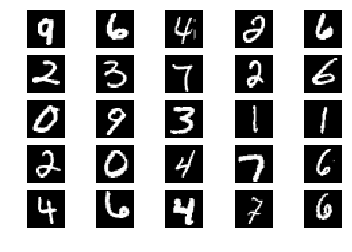

In [3]:
from keras.datasets import mnist
from keras.utils import np_utils

# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Display some of the samples
plot_samples(X_train)
X_train.shape

We flatten and normalize images:

In [4]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Categories need to be converted to one-hot vectors for training:

In [5]:
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
y_train, Y_train

(array([5, 0, 4, ..., 5, 6, 8], dtype=uint8),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]]))

Now let's write the model from the previous exercise in Keras:

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
# in the first layer we need to specify the input shape
model.add(Dense(10, input_shape=(784,)))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 10)            7850        dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10)            0           dense_1[0][0]                    
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
____________________________________________________________________________________________________


**Exercise**: ```model.summary()``` gave us the total number of trainable parameters of our model. How is this number obtained? 

**Answer**: Number of parameters: 10*784 + 10

We are now ready to train. Let's define the optimizer:

In [7]:
from keras.optimizers import SGD
lr = 0.01
# For now we will not decrease the learning rate
decay = 0

optim = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)

In Keras, we need to compile the model to define the loss and the optimizer we want to use. Since we are dealing with a classification problem, we will use the cross entropy loss, which is already defined in keras. Additionally, we will incorporate the accuracy as an additional metric to compute at the end of each epoch:

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

Now let's train the model. ```model.fit()``` will do the training loop for us. We just need to pass the training data ```X_train``` and labels ```Y_train``` as input, specify the ```batch_size``` and the number of epochs ```nb_epoch``` we want to do. We also pass the test set ```(X_test,Y_Test)``` as validation data, which will allow us to see how the model performs on the test data as training progresses. Let's run it:

In [9]:
batch_size = 128
nb_epoch = 30
verbose = 2

t = time.time()
# 30 seconds for 20 epochs on GeForce GTX 980
history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=verbose,validation_data=(X_test, Y_test))

print (time.time() - t, "seconds.")

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
1s - loss: 0.5890 - acc: 0.8459 - val_loss: 0.3800 - val_acc: 0.8991
Epoch 2/30
1s - loss: 0.3746 - acc: 0.8966 - val_loss: 0.3359 - val_acc: 0.9095
Epoch 3/30
1s - loss: 0.3429 - acc: 0.9050 - val_loss: 0.3164 - val_acc: 0.9135
Epoch 4/30
1s - loss: 0.3264 - acc: 0.9091 - val_loss: 0.3056 - val_acc: 0.9159
Epoch 5/30
1s - loss: 0.3159 - acc: 0.9119 - val_loss: 0.2992 - val_acc: 0.9168
Epoch 6/30
1s - loss: 0.3079 - acc: 0.9136 - val_loss: 0.2942 - val_acc: 0.9180
Epoch 7/30
1s - loss: 0.3024 - acc: 0.9157 - val_loss: 0.2902 - val_acc: 0.9188
Epoch 8/30
1s - loss: 0.2974 - acc: 0.9170 - val_loss: 0.2881 - val_acc: 0.9194
Epoch 9/30
1s - loss: 0.2936 - acc: 0.9181 - val_loss: 0.2843 - val_acc: 0.9206
Epoch 10/30
1s - loss: 0.2905 - acc: 0.9189 - val_loss: 0.2824 - val_acc: 0.9215
Epoch 11/30
1s - loss: 0.2874 - acc: 0.9201 - val_loss: 0.2811 - val_acc: 0.9222
Epoch 12/30
1s - loss: 0.2851 - acc: 0.9202 - val_loss: 0.2794 - val

We can plot the loss and accuracy curves with the ```history``` object returned by ```model.fit()```. The function ````plot_curves```, which is defined in ```utils.py``` will do this for us.

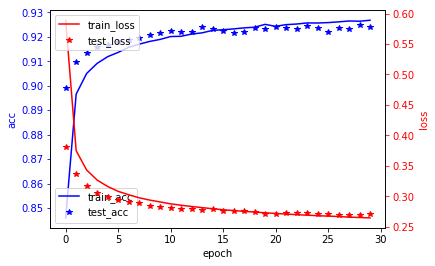

In [10]:
plot_curves(history,nb_epoch)

The curve trend indicates that the model may be able to improve if we train it for longer, but for now let's leave it here.

Let's now evaluate our model. ```model.evaluate()``` will take all the test samples, forward them through the network and return the average loss, and any additional metrics we specified (in our case, the accuracy).

In [11]:
score = model.evaluate(X_test, Y_test, verbose=0)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))

Loss: 0.269971
Accuracy: 0.923900


We reach an accuracy of 92%, which is similar to the one we obtained in the previous exercise.

## Single hidden layer

Let's try to train a model with a hidden layer between the input and the classifier. 

**Exercise**: Modify the previous architecture to include this layer with 128 neurons. Make sure to use a non-linearity between the two layers (e.g. ReLU). Also remember that, in keras, the ```input_shape``` must be passed to the first layer of the network. 

In [12]:
import numpy as np
np.random.seed(SEED)

# MODEL DEFINITION
model = Sequential()

model.add(Dense(128, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_2 (Dense)                  (None, 128)           100480      dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 128)           0           dense_2[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 10)            1290        activation_2[0][0]               
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 10)            0           dense_3[0][0]                    
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
___________________

**Exercise**: Compute the number of parameters and check if they match the ones given by ```model.summary()```

**Answer**:

In [13]:
in_dim = 784
hidden_dim = 128
cls_dim = 10

hidden_dim*in_dim + hidden_dim + hidden_dim*cls_dim+cls_dim

101770

Let's train the model you just defined. Notice that the compilation and training code did not change at all:

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
1s - loss: 0.4914 - acc: 0.8648 - val_loss: 0.2769 - val_acc: 0.9223
Epoch 2/30
1s - loss: 0.2607 - acc: 0.9264 - val_loss: 0.2209 - val_acc: 0.9395
Epoch 3/30
1s - loss: 0.2096 - acc: 0.9417 - val_loss: 0.1839 - val_acc: 0.9471
Epoch 4/30
1s - loss: 0.1771 - acc: 0.9500 - val_loss: 0.1625 - val_acc: 0.9551
Epoch 5/30
1s - loss: 0.1540 - acc: 0.9564 - val_loss: 0.1436 - val_acc: 0.9599
Epoch 6/30
1s - loss: 0.1362 - acc: 0.9619 - val_loss: 0.1329 - val_acc: 0.9615
Epoch 7/30
1s - loss: 0.1226 - acc: 0.9660 - val_loss: 0.1244 - val_acc: 0.9645
Epoch 8/30
1s - loss: 0.1111 - acc: 0.9696 - val_loss: 0.1167 - val_acc: 0.9652
Epoch 9/30
1s - loss: 0.1020 - acc: 0.9719 - val_loss: 0.1104 - val_acc: 0.9669
Epoch 10/30
1s - loss: 0.0945 - acc: 0.9740 - val_loss: 0.1044 - val_acc: 0.9697
Epoch 11/30
1s - loss: 0.0879 - acc: 0.9762 - val_loss: 0.0989 - val_acc: 0.9700
Epoch 12/30
1s - loss: 0.0819 - acc: 0.9776 - val_loss: 0.0932 - val

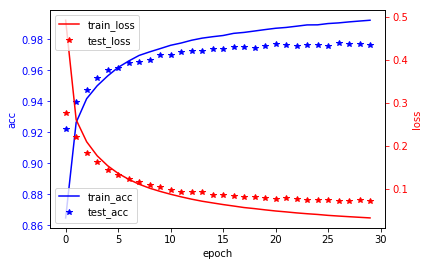

In [14]:
# COMPILE & TRAIN
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

t = time.time()
history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=2,validation_data=(X_test, Y_test))
print (time.time() - t, "seconds.")

score = model.evaluate(X_test, Y_test, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))
plot_curves(history,nb_epoch)

So, adding a hidden layer pushed the accuracy from 0.92 to almost 0.98. Of course the number of parameters has increased significantly. 

## Going deep

Can we keep adding layers just like that and get better and better accuracy? 

**Exercise**: Design and train network with 6 hidden layers with 128 neurons + classifier.

In [15]:
import numpy as np
np.random.seed(SEED)

H_DIM = 128
model = Sequential()
model.add(Dense(H_DIM, input_shape=(784,)))
model.add(Activation('relu'))
for i in range(5):
    model.add(Dense(H_DIM))
    model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 128)           100480      dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 128)           0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 128)           16512       activation_4[0][0]               
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 128)           0           dense_5[0][0]                    
___________________________________________________________________________________________

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
2s - loss: 0.5982 - acc: 0.8105 - val_loss: 0.2116 - val_acc: 0.9339
Epoch 2/30
2s - loss: 0.1566 - acc: 0.9532 - val_loss: 0.1397 - val_acc: 0.9566
Epoch 3/30
1s - loss: 0.1110 - acc: 0.9664 - val_loss: 0.1134 - val_acc: 0.9634
Epoch 4/30
1s - loss: 0.0852 - acc: 0.9744 - val_loss: 0.0934 - val_acc: 0.9712
Epoch 5/30
2s - loss: 0.0693 - acc: 0.9796 - val_loss: 0.0961 - val_acc: 0.9700
Epoch 6/30
1s - loss: 0.0569 - acc: 0.9829 - val_loss: 0.0870 - val_acc: 0.9729
Epoch 7/30
2s - loss: 0.0475 - acc: 0.9849 - val_loss: 0.0926 - val_acc: 0.9697
Epoch 8/30
2s - loss: 0.0391 - acc: 0.9878 - val_loss: 0.0898 - val_acc: 0.9748
Epoch 9/30
1s - loss: 0.0337 - acc: 0.9892 - val_loss: 0.0977 - val_acc: 0.9710
Epoch 10/30
2s - loss: 0.0271 - acc: 0.9915 - val_loss: 0.0908 - val_acc: 0.9751
Epoch 11/30
1s - loss: 0.0259 - acc: 0.9913 - val_loss: 0.0890 - val_acc: 0.9774
Epoch 12/30
2s - loss: 0.0202 - acc: 0.9936 - val_loss: 0.0983 - val

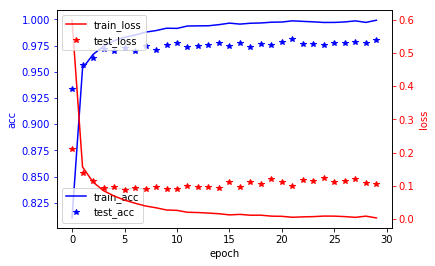

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
t = time.time()
history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=2,validation_data=(X_test, Y_test))
print (time.time() - t, "seconds.")

score = model.evaluate(X_test, Y_test, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))
plot_curves(history,nb_epoch)

Turns out that adding more layers did not do much for us. Accuracy is pretty much the same as the one we obtained with a single hidden layer, and now our model is overfitting to training data. How can we fix this?

## Dropout

**Exercise**: Add dropout layer(s) to the model and see how their effect in the training curves & accuracy.

In [17]:
import numpy as np
np.random.seed(SEED)

from keras.layers import Dropout

dratio = 0.2
H_DIM = 128

model = Sequential()
model.add(Dense(H_DIM, input_shape=(784,)))
model.add(Activation('relu'))

for i in range(4):
    model.add(Dense(H_DIM))
    model.add(Activation('relu'))
    if i%2 == 0:
        model.add(Dropout(dratio))
    
model.add(Dense(10))
model.add(Activation('softmax'))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
2s - loss: 0.6924 - acc: 0.7768 - val_loss: 0.2061 - val_acc: 0.9359
Epoch 2/30
2s - loss: 0.2193 - acc: 0.9349 - val_loss: 0.1491 - val_acc: 0.9556
Epoch 3/30
1s - loss: 0.1595 - acc: 0.9525 - val_loss: 0.1194 - val_acc: 0.9623
Epoch 4/30
2s - loss: 0.1260 - acc: 0.9628 - val_loss: 0.1040 - val_acc: 0.9666
Epoch 5/30
2s - loss: 0.1059 - acc: 0.9679 - val_loss: 0.0963 - val_acc: 0.9708
Epoch 6/30
2s - loss: 0.0926 - acc: 0.9726 - val_loss: 0.0892 - val_acc: 0.9725
Epoch 7/30
2s - loss: 0.0779 - acc: 0.9761 - val_loss: 0.0807 - val_acc: 0.9744
Epoch 8/30
1s - loss: 0.0709 - acc: 0.9788 - val_loss: 0.0821 - val_acc: 0.9756
Epoch 9/30
2s - loss: 0.0625 - acc: 0.9812 - val_loss: 0.0755 - val_acc: 0.9775
Epoch 10/30
1s - loss: 0.0546 - acc: 0.9828 - val_loss: 0.0843 - val_acc: 0.9764
Epoch 11/30
2s - loss: 0.0506 - acc: 0.9841 - val_loss: 0.0915 - val_acc: 0.9748
Epoch 12/30
2s - loss: 0.0473 - acc: 0.9850 - val_loss: 0.0788 - val

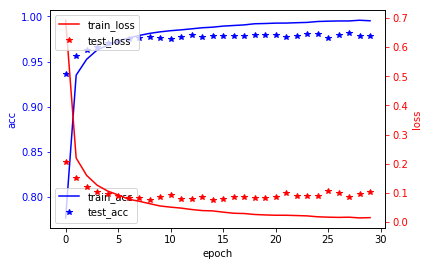

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
t = time.time()
history = model.fit(X_train, Y_train,
                batch_size=batch_size, nb_epoch=nb_epoch,
                verbose=verbose,validation_data=(X_test, Y_test))
print (time.time() - t, "seconds.")

score = model.evaluate(X_test, Y_test, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))
plot_curves(history,nb_epoch)

### Additional exercises:

- Use one of the networks to study the effect of the following components:
    - learning rate
    - optimizer (you can find a list of the different optimizers available in keras [here](https://keras.io/optimizers/))
    - learning rate decay
- Try adding weight regularization in the hidden layers of the network. You can check how to do this in the documentation for [Dense layers](https://keras.io/layers/core/) and [Regularizers](https://keras.io/regularizers/) in keras.